In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!unzip /content/drive/MyDrive/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34905.jpg  
  inflating: real_v

In [ ]:

import torch
from transformers import ViTModel, ViTConfig, ViTFeatureExtractor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np



class ViTModelWithAttention(ViTModel):
    def __init__(self, config):
        super().__init__(config)

    def forward(self, pixel_values, output_attentions=True):
        outputs = super().forward(pixel_values, output_attentions=output_attentions)
        return outputs, pixel_values.device  # Return outputs and device


In [ ]:

# Function to load a model with adjusted keys
def load_model(model_path):
    config = ViTConfig.from_pretrained('google/vit-base-patch16-224', output_attentions=True)
    model = ViTModelWithAttention(config)

    # Load the state dictionary and adjust the keys
    state_dict = torch.load(model_path)
    adjusted_state_dict = {key.replace('vit.', ''): value for key, value in state_dict.items() if 'vit.' in key}

    # Load the state dictionary into the model with strict mode off
    model.load_state_dict(adjusted_state_dict, strict=False)
    model.eval()
    return model



In [ ]:
def get_attention_map(model, image_path):
    feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
    image = Image.open(image_path)
    inputs = feature_extractor(images=image, return_tensors="pt").to(model.device)

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract attention weights
    # Check how the model's output is structured and adapt accordingly
    if hasattr(outputs, 'attentions'):
        attentions = outputs.attentions
    elif isinstance(outputs, tuple):
        # Find the tuple element that contains the attentions
        for output in outputs:
            if isinstance(output, torch.Tensor):
                continue
            if hasattr(output, 'attentions'):
                attentions = output.attentions
                break
        else:
            raise ValueError("Model outputs do not contain attention weights")
    else:
        raise ValueError("Model outputs do not contain attention weights")

    # Take the attention weights from one of the last layers
    attention = attentions[-1][0, 0].cpu().numpy()

    return attention


In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [ ]:
import torch

# Path to your saved model weights
model_path = '/content/drive/MyDrive/pretrained weights/vit_model.pth'

# Load the saved model weights onto CPU
model_weights = torch.load(model_path, map_location=torch.device('cpu'))

# Print the keys in the model weights
print("Keys in the saved model's state_dict:")
for key in model_weights.keys():
    print(key)


Keys in the saved model's state_dict:
vit.embeddings.cls_token
vit.embeddings.position_embeddings
vit.embeddings.patch_embeddings.projection.weight
vit.embeddings.patch_embeddings.projection.bias
vit.encoder.layer.0.attention.attention.query.weight
vit.encoder.layer.0.attention.attention.query.bias
vit.encoder.layer.0.attention.attention.key.weight
vit.encoder.layer.0.attention.attention.key.bias
vit.encoder.layer.0.attention.attention.value.weight
vit.encoder.layer.0.attention.attention.value.bias
vit.encoder.layer.0.attention.output.dense.weight
vit.encoder.layer.0.attention.output.dense.bias
vit.encoder.layer.0.intermediate.dense.weight
vit.encoder.layer.0.intermediate.dense.bias
vit.encoder.layer.0.output.dense.weight
vit.encoder.layer.0.output.dense.bias
vit.encoder.layer.0.layernorm_before.weight
vit.encoder.layer.0.layernorm_before.bias
vit.encoder.layer.0.layernorm_after.weight
vit.encoder.layer.0.layernorm_after.bias
vit.encoder.layer.1.attention.attention.query.weight
vit.enc

In [ ]:
pre_tuned_model = load_model('/content/drive/MyDrive/pretrained weights/vit_model.pth')
post_tuned_model = load_model('/content/drive/MyDrive/pretrained weights/vit_model_finetuned.pth')



config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

In [ ]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def overlay_attention_map(image, attention_map, title):
    # Flatten the 2D attention map if it's not already 1D
    if len(attention_map.shape) == 2:
        attention_map = attention_map.flatten()

    # Calculate the number of patches along width and height
    num_patches_side = int(np.sqrt(len(attention_map)))

    # Resize the attention map to match the image dimensions
    attention_map_resized = attention_map.reshape((num_patches_side, num_patches_side))
    attention_map_resized = np.resize(attention_map_resized, (image.size[1], image.size[0]))

    # Normalize the attention map values
    attention_map_resized = (attention_map_resized - attention_map_resized.min()) / (attention_map_resized.max() - attention_map_resized.min())

    # Create a heatmap with the attention map
    heatmap = plt.get_cmap('jet')(attention_map_resized)

    # Overlay the heatmap on the original image
    overlaid_image = Image.fromarray((heatmap[:, :, :3] * 255).astype(np.uint8))

    # Blend the images using alpha blending
    blended_image = Image.blend(image.convert('RGBA'), overlaid_image.convert('RGBA'), alpha=0.5)

    # Draw attention points on the blended image
    draw = ImageDraw.Draw(blended_image)
    attention_points = np.argwhere(attention_map_resized > 0.5)  # You can adjust the threshold as needed
    for point in attention_points:
        draw.rectangle([point[1], point[0], point[1] + 1, point[0] + 1], fill=(255, 0, 0, 128))  # Red semi-transparent points

    return blended_image



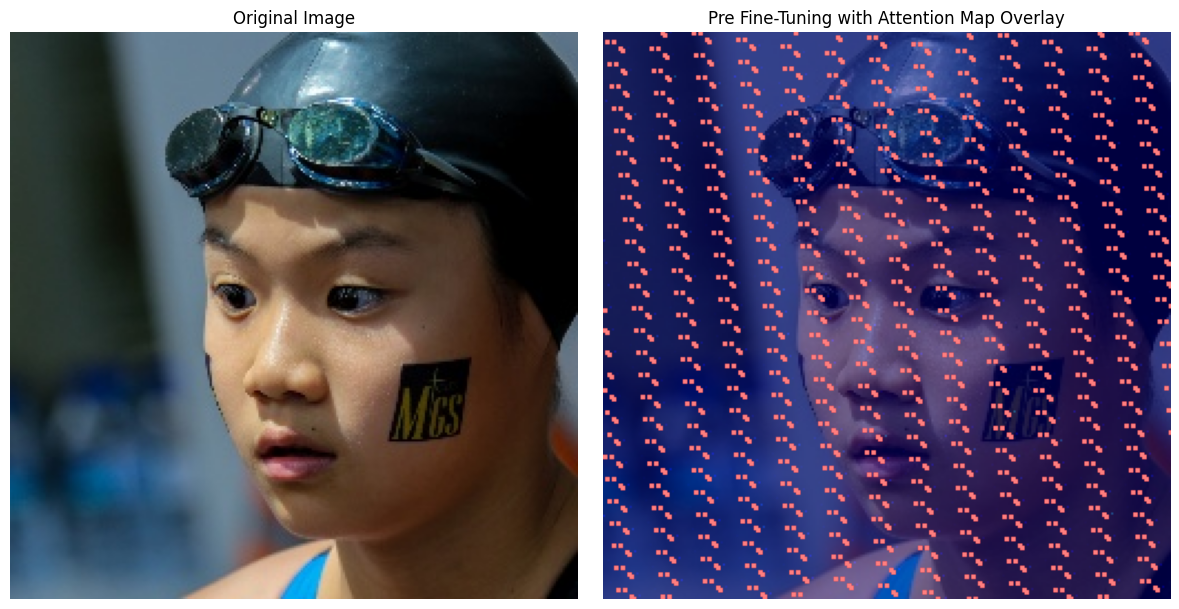

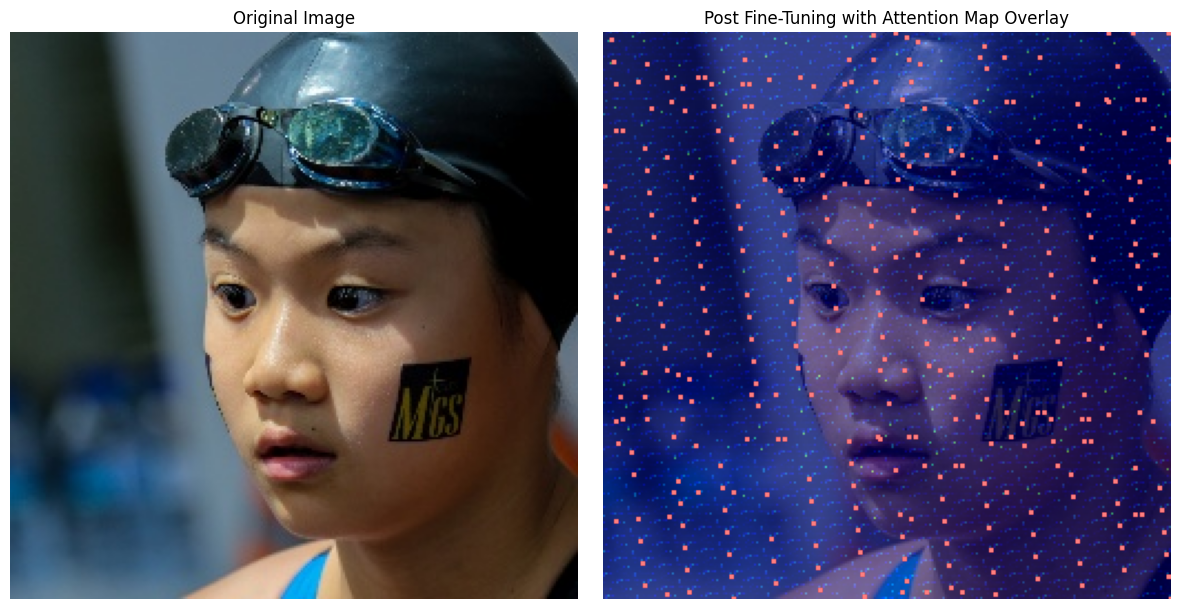

In [ ]:
# Load your image
real_image_path = '/content/real_vs_fake/real-vs-fake/test/real/04801.jpg'
image = Image.open(real_image_path)

# Get attention maps
attention_pre = get_attention_map(pre_tuned_model, real_image_path)
attention_post = get_attention_map(post_tuned_model, real_image_path)

# Display original image and attention map for pre-tuned weights
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display original image
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display attention map overlay for pre-tuned weights
overlay_pre = overlay_attention_map(image, attention_pre, 'Pre Fine-Tuning real Image')
axes[1].imshow(overlay_pre)
axes[1].set_title('Pre Fine-Tuning with Attention Map Overlay')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Display original image and attention map for post-tuned weights
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display original image
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display attention map overlay for post-tuned weights
overlay_post = overlay_attention_map(image, attention_post, 'Post Fine-Tuning real Image')
axes[1].imshow(overlay_post)
axes[1].set_title('Post Fine-Tuning with Attention Map Overlay')
axes[1].axis('off')

plt.tight_layout()
plt.show()


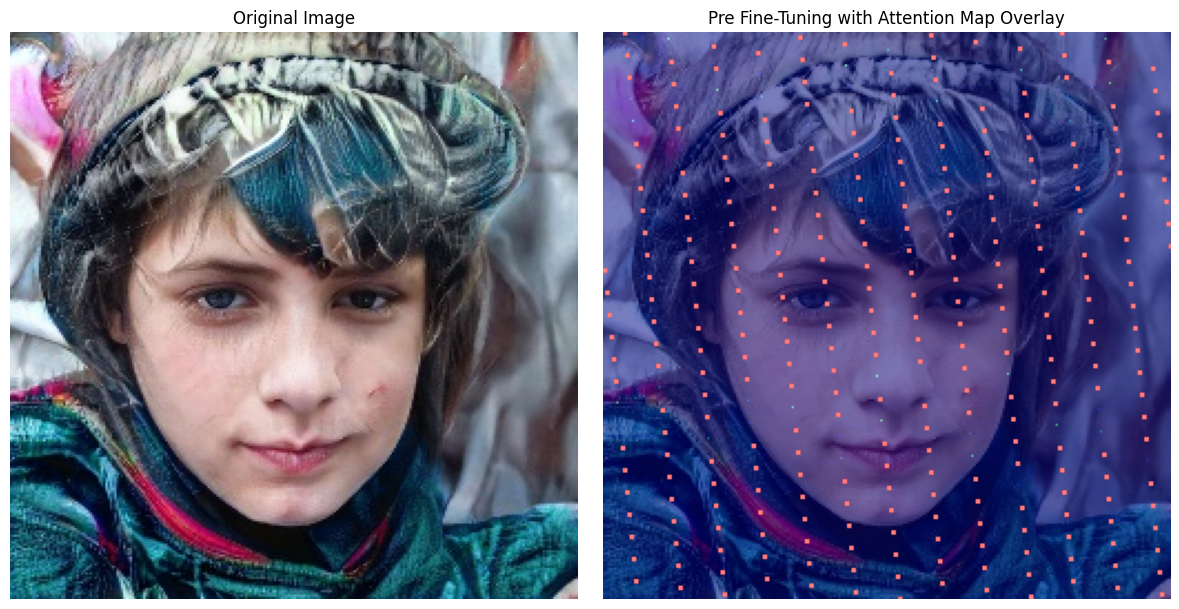

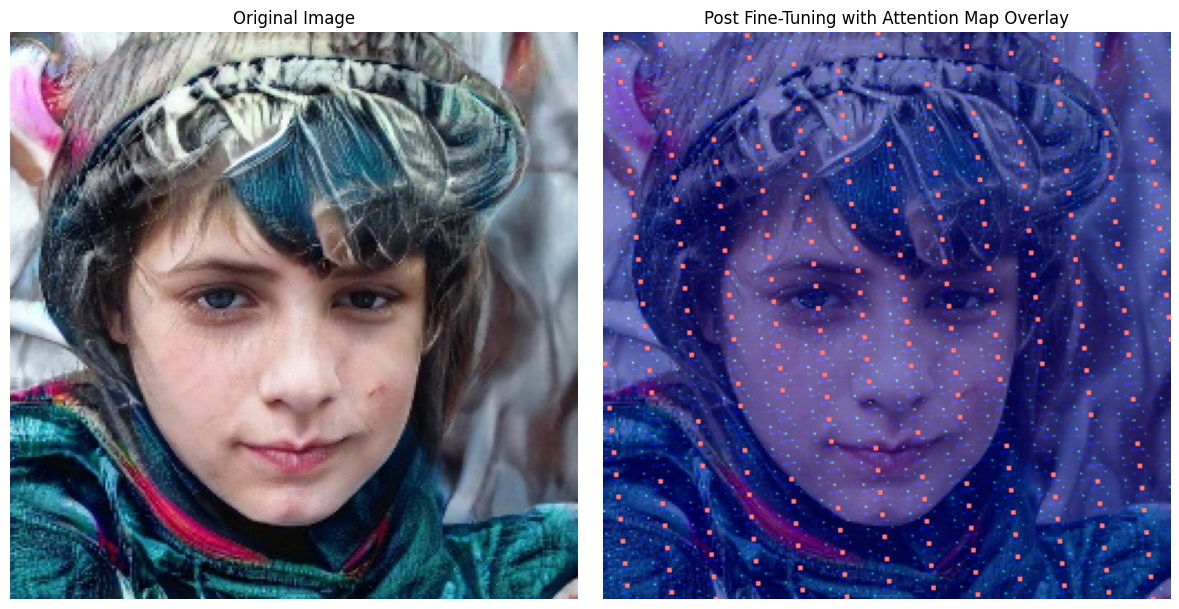

In [ ]:


# Load your image
fake_image_path = '/content/real_vs_fake/real-vs-fake/test/fake/06TAEXDQGR.jpg'
image = Image.open(fake_image_path)

# Get attention maps
attention_pre = get_attention_map(pre_tuned_model, fake_image_path)
attention_post = get_attention_map(post_tuned_model, fake_image_path)

# Display original image and attention map for pre-tuned weights
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display original image
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display attention map overlay for pre-tuned weights
overlay_pre = overlay_attention_map(image, attention_pre, 'Pre Fine-Tuning fake Image')
axes[1].imshow(overlay_pre)
axes[1].set_title('Pre Fine-Tuning with Attention Map Overlay')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Display original image and attention map for post-tuned weights
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display original image
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display attention map overlay for post-tuned weights
overlay_post = overlay_attention_map(image, attention_post, 'Post Fine-Tuning fake Image')
axes[1].imshow(overlay_post)
axes[1].set_title('Post Fine-Tuning with Attention Map Overlay')
axes[1].axis('off')

plt.tight_layout()
plt.show()
